In [ ]:
import torch, gc
import os
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
from torchvision.datasets.utils import download_url
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
# download_url(dataset_url, '.')

# # Extract from archive
# with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
#     tar.extractall(path='./data')
    
# # Look into the data directory
# data_dir = './data/cifar10'
# print(os.listdir(data_dir))
# classes = os.listdir(data_dir + "/train")
# print(classes)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile

In [ ]:
data_path = '/content/drive/MyDrive/dataset_simp.zip'

In [ ]:
with ZipFile(data_path,'r') as zip:
  zip.extractall(path='/')

In [ ]:

stats = ((0.4669, 0.4128, 0.3577), (0.2468, 0.2239, 0.2514))

In [ ]:
train_tfms = tt.Compose([tt.RandomCrop(32,padding=4,padding_mode='reflect'),
                        tt.RandomHorizontalFlip(),
                        
                        
                        tt.ToTensor(),
                        tt.Normalize(*stats,inplace=True)
                        ])
test_tfms = tt.Compose([tt.ToTensor(),tt.Normalize(*stats)])

In [ ]:
train_ds = ImageFolder('/dataset_simp/train',train_tfms)
test_ds = ImageFolder('/dataset_simp/test',test_tfms)

In [ ]:
batch_size = 32

In [ ]:
train_dl = DataLoader(train_ds,batch_size,shuffle=True,num_workers=3,pin_memory=True)
test_dl = DataLoader(test_ds,batch_size*2,num_workers=3,pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def denormalize(images,means,stds):
    means = torch.tensor(means).reshape(1,3,1,1)
    stds = torch.tensor(stds).reshape(1,3,1,1)
    return images*stds+means

def show_batch(dl):
    for images,labels in dl:
        fig, ax = plt.subplots(figsize=(12,12))
        ax.set_xticks([]);ax.set_yticks([])
        denorm_images =  denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1,2,0).clamp(0,1))
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


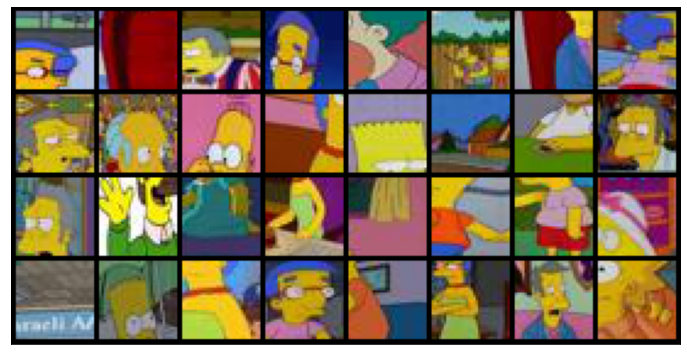

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:


class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.norm15 = nn.BatchNorm2d(15)
        self.norm30 = nn.BatchNorm2d(30)
        self.norm60 = nn.BatchNorm2d(60)
        self.norm120 = nn.BatchNorm2d(120)
        self.norm200 = nn.BatchNorm2d(200)
        self.norm300 = nn.BatchNorm2d(300)
        self.norm360 = nn.BatchNorm2d(360)
        self.norm512 = nn.BatchNorm2d(512)
        #--------------------
        self.conv15 = nn.Conv2d(3,15,kernel_size=3,stride=1,padding=1)#15x64x64
        self.conv30 = nn.Conv2d(15,30,kernel_size=3,stride=1,padding=1)#30x64x64
        self.conv60 = nn.Conv2d(30,60,kernel_size=3,stride=2,padding=1)#60x32x32

        self.res60 = nn.Conv2d(60,60,kernel_size=3,stride=1,padding=1)
        #---------------
        self.conv120a = nn.Conv2d(60,60,kernel_size=3,stride=1,padding=1)
        #------------
        self.conv200 = nn.Conv2d(60,200,kernel_size=3,stride=1,padding=1)#200x32x32
        self.conv200a = nn.Conv2d(200,200,kernel_size=3,stride=2,padding=1)#200x16x16
        

        self.res200 = nn.Conv2d(200,200,kernel_size=3,stride=1,padding=1)
        #------------------
        self.conv300 = nn.Conv2d(200,200,kernel_size=3,stride=1,padding=1)
        self.conv360 = nn.Conv2d(200,360,kernel_size=3,stride=1,padding=1)#360x16x16
        self.conv512 = nn.Conv2d(360,512,kernel_size=3,stride=1,padding=1)#512x16x16

        

        #===========================#
        self.pool = nn.MaxPool2d(2,2)
        self.avgpool = nn.AvgPool2d(2,2)
        self.flat = nn.Flatten()

        self.linear = nn.Linear(512,10)

    def forward(self,xb):
      out = torch.relu(self.norm15(self.conv15(xb)))#15x64x64

      out = torch.relu(self.norm30(self.conv30(out)))#30x64x64

      out = torch.relu(self.norm60(self.conv60(out)))#60x32x32

      x = self.res60(out)#120x32x32

      out = torch.relu(self.conv120a(out)+x)

      out = torch.relu(self.norm200(self.conv200(out)))

      out = torch.relu(self.conv200a(out))

      

      x = self.res200(out)

      out = torch.relu(self.conv300(out)+x)

      out = torch.relu(self.norm360(self.conv360(out)))

      out = torch.relu(self.norm512(self.conv512(out)))

      out = self.avgpool(out)#512x8x8
      out = self.avgpool(out)#512 4 4
      out = self.avgpool(out)
      
      out = self.flat(out)
      out = self.linear(out)

      return out




In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
model = to_device(ResNet9(3,10),device)
model

ResNet9(
  (norm15): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm30): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm60): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm120): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm200): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm300): BatchNorm2d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm360): BatchNorm2d(360, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm512): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv15): Conv2d(3, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv30): Conv2d(15, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv60): Conv2d(30, 60, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (res60): C

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, test_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.09765625, 'val_loss': 2.3025496006011963}]

In [ ]:
for image,labels in train_dl:
  print(image.shape)
  out = model(image)
  print(out.shape)
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([32, 3, 32, 32])
torch.Size([32, 10])


In [ ]:
epochs = 20
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
fit_one_cycle(5,max_lr,model,train_dl,test_dl,weight_decay,grad_clip,opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], last_lr: 0.00759, train_loss: 1.6906, val_loss: 2.2377, val_acc: 0.1500
Epoch [1], last_lr: 0.00950, train_loss: 1.8426, val_loss: 2.2662, val_acc: 0.1443
Epoch [2], last_lr: 0.00611, train_loss: 1.7231, val_loss: 2.2256, val_acc: 0.1775
Epoch [3], last_lr: 0.00188, train_loss: 1.5426, val_loss: 2.2250, val_acc: 0.1775
Epoch [4], last_lr: 0.00000, train_loss: 1.4036, val_loss: 2.2042, val_acc: 0.1994


[{'lrs': [0.0003999999999999993,
   0.00040016934221227124,
   0.0004006773569004262,
   0.0004015240082193266,
   0.00040270923642988544,
   0.00040423295790328537,
   0.0004060950651268713,
   0.0004082954267117453,
   0.00041083388740203487,
   0.0004137102680858394,
   0.0004169243658078865,
   0.0004204759537838332,
   0.00042436478141627716,
   0.0004285905743124357,
   0.0004331530343035118,
   0.00043805183946572616,
   0.0004432866441430351,
   0.00044885707897152245,
   0.0004547627509054516,
   0.0004610032432450159,
   0.0004675781156657198,
   0.00047448690424946316,
   0.0004817291215172704,
   0.0004893042564636865,
   0.0004972117745928317,
   0.0005054511179561193,
   0.0005140217051916134,
   0.0005229229315650685,
   0.0005321541690125782,
   0.0005417147661849059,
   0.0005516040484934374,
   0.0005618213181577784,
   0.0005723658542549932,
   0.0005832369127704677,
   0.0005944337266504118,
   0.0006059555058559787,
   0.0006178014374190084,
   0.000629970685499395

In [ ]:
from fastai.basic_data import DataBunch
from fastai.train import Learner
from fastai.metrics import accuracy

In [ ]:
data = DataBunch.create(train_ds,test_ds,bs =batch_size,path='/')
learner = Learner(data,model,loss_func=F.cross_entropy,metrics=[accuracy])
learner.clip=0.1

In [ ]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


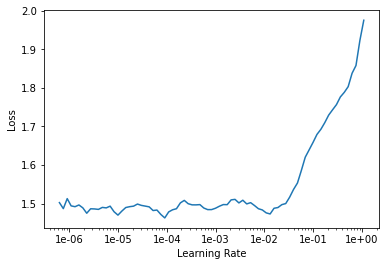

In [ ]:
learner.recorder.plot()

In [ ]:
learner.fit_one_cycle(9,5e-3,wd=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.373821,2.317430,0.061000,00:14
1,1.440837,2.301823,0.111000,00:14
2,1.428772,2.309239,0.107000,00:14
3,1.321113,2.297119,0.099000,00:14
4,1.212275,2.313455,0.100000,00:14
5,1.157898,2.312361,0.092000,00:14
6,1.026731,2.303431,0.111000,00:14
7,0.960100,2.319115,0.100000,00:14
8,0.936490,2.318288,0.099000,00:14


In [ ]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: moe , Predicted: principal


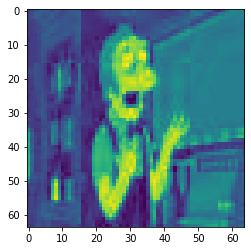

In [ ]:
img, label = test_ds[735]
plt.imshow(img[0])
print('Label:', train_ds.classes[label], ', Predicted:', train_ds.classes[predict_image(img, model)])